In [1]:
from typing import Iterable
import numpy as np
import xarray as xr
import itertools
import multiprocessing as mp

import sys
sys.path.append("../../../gradboost_pv/")


from gradboost_pv.preprocessing.region_filtered import (
    get_eso_uk_multipolygon,
    generate_polygon_mask,
    NWPUKRegionMaskedDatasetBuilder,
)

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/nowcasting_datamodel/models/forecast.py:196: SAWarning: This declarative base already contains a class with the same class name and module name as nowcasting_datamodel.models.forecast.ForecastValueYearMonth, and will be replaced in the string-lookup table.
  class ForecastValueYearMonth(ForecastValueSQLMixin, Base_Forecast):


Unable to import PVLive utils, please provide filenames with OpenGSP
Unable to import PVLive utils, please provide filenames with OpenGSP


In [24]:
NWP_PATH = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_6.zarr/"
GSP_PATH = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"

gsp = xr.open_zarr(GSP_PATH)
nwp = xr.open_zarr(NWP_PATH, chunks={"step": 1, "variable": 1, "init_time": 50})
# nwp = nwp.chunk({"variable": 1, "step": 1})

evaluation_timeseries = (
    gsp.coords["datetime_gmt"]
    .where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0])
        & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]),
        drop=True,
    )
    .values
)

# dset_builder = NWPUKRegionMaskedDatasetBuilder(nwp, evaluation_timeseries)

# FORECAST_HORIZONS = range(2)
# VARIABLES = range(2)

# iter_params = list(itertools.product(VARIABLES, FORECAST_HORIZONS))

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "variable" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "step" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [29]:
import pandas as pd
years = pd.DatetimeIndex(nwp.init_time.values).year.unique()

In [30]:
years

Int64Index([2016, 2017, 2018, 2019, 2020, 2021], dtype='int64')

In [32]:
evaluation_timeseries

array(['2016-03-22T15:00:00.000000000', '2016-03-22T15:30:00.000000000',
       '2016-03-22T16:00:00.000000000', ...,
       '2021-11-08T14:00:00.000000000', '2021-11-08T14:30:00.000000000',
       '2021-11-08T15:00:00.000000000'], dtype='datetime64[ns]')

In [31]:
nwp.sel(init_time=slice(    years[0], years[1]))

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [2016] of type int64

In [27]:
nwp.groupby(nwp.init_time.year)

AttributeError: 'numpy.ndarray' object has no attribute 'year'

In [3]:
from gradboost_pv.inference.data_feeds import MockDataFeed

In [4]:
from gradboost_pv.inference.data_feeds import MockDataFeed

nwp = nwp.sel(init_time=slice(np.datetime64("2020-02-02T00:00:00"), np.datetime64("2020-02-09T00:00:00")))
_gsp = gsp.sel(datetime_gmt=slice(nwp.coords["init_time"].values[0] - np.timedelta64(1, "D"), nwp.coords["init_time"].values[-1]))
_gsp = _gsp.isel(gsp_id=0)
df = MockDataFeed(nwp, _gsp)

count = 0
results = []

for x in df:
    results.append(x)
    if count > 10:
        break
    count +=1

In [5]:
from gradboost_pv.inference.models import NationalBoostInferenceModel

def fake():
    pass

model = NationalBoostInferenceModel({}, fake, nwp.coords["x"].values, nwp.coords["y"].values)
model.initialise()

/home/tom/dev/gradboost_pv/gradboost_pv/preprocessing/region_filtered.py:43: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return MultiPolygon(


In [6]:
out = model.covariate_transform(results[0])

inner mask took 24.003096921835095
outer mask took 23.957110792165622
pandas casting took: 0.00192698510363698
LR beta took 0.0008495100773870945


In [9]:
test_a = {
    1: 0,
    2: 500,
    3: 49
}

In [10]:
def add_1(x):
    return x+1

In [18]:
map(add_1, test_a)

In [8]:
out.covariates

,cdcb_within,lcc_within,mcc_within,hcc_within,sde_within,hcct_within,dswrf_within,dlwrf_within,h_within,t_within,...,dpt_diff,vis_diff,si10_diff,wdir10_diff,prmsl_diff,prate_diff,PV_LAG_2HR,PV_LAG_1HR,PV_LAG_DAY,LR_Beta
0,3231.034424,24.191299,37.883724,64.361809,0.000379,-32313.464844,0.000000,288.992584,1152.980347,277.576508,...,-1.590851,-6490.794922,-4.073385,-20.403641,275.976562,-0.000044,0.000000,0.000000,0.000000,0.0
1,2675.672852,30.128849,53.290272,71.051567,0.000379,-32026.865234,0.000000,295.047577,1180.673950,277.568542,...,-1.522430,-8810.287109,-4.052905,-29.249191,230.117188,-0.000032,0.000000,0.000000,0.000000,0.0
2,2034.438843,40.425770,62.122524,74.229271,0.000379,-32014.787109,0.000000,300.322388,1205.302124,277.583374,...,-1.394135,-11493.527344,-3.925403,-36.271545,190.328125,0.000048,0.000000,0.000000,0.000000,0.0
3,1564.291382,52.987682,67.220825,73.216995,0.000379,-32095.496094,0.000000,305.511139,1228.098999,277.577881,...,-1.276367,-14394.116211,-3.719765,-47.520691,112.601562,0.000104,0.000000,0.000000,0.000000,0.0
4,1233.015381,63.048363,68.844200,72.692444,0.000379,-31925.857422,0.000000,309.747620,1282.181152,277.645172,...,-1.175049,-16292.148438,-3.318425,-54.295441,24.109375,0.000107,0.000000,0.000000,0.000000,0.0
5,1025.909546,70.746750,65.676575,71.236969,0.000380,-31848.265625,0.000000,313.542603,1358.372314,277.776398,...,-1.035645,-17704.421875,-2.901943,-49.224716,-24.828125,0.000100,0.000000,0.000000,0.000000,0.0
6,1003.909302,72.539444,58.518635,63.021866,0.000382,-31868.267578,0.000000,314.537079,1423.744751,277.924377,...,-0.932831,-16826.748047,-2.698771,-39.451965,-57.476562,0.000097,0.000000,0.000000,0.000000,0.0
7,1084.592041,69.370430,49.454586,48.296143,0.000393,-31893.873047,0.000000,312.790100,1459.210815,278.110596,...,-0.884033,-15358.347656,-2.619263,-33.740662,-69.257812,0.000033,0.000000,0.000000,0.000000,0.0
8,1245.904785,64.567902,42.945370,38.226753,0.000398,-32014.572266,5.913399,309.487549,1469.127808,278.287598,...,-0.901917,-13881.332031,-2.546154,-28.045288,-73.859375,-0.000007,0.008659,0.008659,0.008659,0.0
9,1723.415161,60.694023,41.441780,44.959999,0.000406,-31821.320312,44.110252,307.771210,1434.316406,278.589294,...,-0.829315,-14478.062500,-2.449936,-17.981247,-59.632812,-0.000015,0.110190,0.110190,0.110190,0.0


In [13]:
results[0]["gsp"].isel(datetime_gmt=-1)["installedcapacity_mwp"].values.item()

13081.542

In [20]:
mask = model.mask

In [16]:
_nwp = results[0]["nwp"]

In [17]:
_nwp

<xarray.Dataset>
Dimensions:    (variable: 17, step: 37, y: 704, x: 548)
Coordinates:
    init_time  datetime64[ns] 2020-02-02
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000
Data variables:
    UKV        (variable, step, y, x) float32 dask.array<chunksize=(1, 1, 352, 274), meta=np.ndarray>

In [23]:
_nwp = _nwp.chunk({"variable":1, "step": 1, "y":704, "x":548})

_X = (_nwp * mask).mean(dim=["x", "y"]).to_array().values

In [37]:
_mask = mask.values[0, :, :, :].reshape(37, 704, 548)

In [38]:
for var in _nwp.coords["variable"].values:
    __nwp = _nwp.sel(variable=var)
    _X = (__nwp * _mask).mean(dim=["x", "y"]).to_array().values

KeyboardInterrupt: 

In [39]:
__nwp = _nwp.isel(variable=5, step=20)

In [40]:
__nwp 

<xarray.Dataset>
Dimensions:    (y: 704, x: 548)
Coordinates:
    init_time  datetime64[ns] 2020-02-02
    step       timedelta64[ns] 20:00:00
    variable   <U6 'hcct'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000
Data variables:
    UKV        (y, x) float32 dask.array<chunksize=(704, 548), meta=np.ndarray>

In [47]:
(__nwp * _mask[0, :, :]).mean(dim=["x", "y"]).to_array().values

array([-12323.14728301])

In [52]:
__nwp_np = __nwp.chunk({"x": 548, "y": 704}).as_numpy()

In [60]:
__nwp_np.to_array().values.itemsize

4

In [10]:
gsp

<xarray.Dataset>
Dimensions:                (datetime_gmt: 150865, gsp_id: 318)
Coordinates:
  * datetime_gmt           (datetime_gmt) datetime64[ns] 2014-01-01 ... 2022-...
  * gsp_id                 (gsp_id) int64 0 1 2 3 4 5 ... 313 314 315 316 317
Data variables:
    generation_mw          (datetime_gmt, gsp_id) float64 dask.array<chunksize=(9430, 20), meta=np.ndarray>
    installedcapacity_mwp  (datetime_gmt, gsp_id) float64 dask.array<chunksize=(9430, 20), meta=np.ndarray>

In [12]:
test = out[2]

In [13]:
test

,target
2020-02-01 00:00:00,0.000000
2020-02-01 00:30:00,0.000000
2020-02-01 01:00:00,0.000000
2020-02-01 01:30:00,0.000000
2020-02-01 02:00:00,0.000000
2020-02-01 02:30:00,0.000000
2020-02-01 03:00:00,0.000000
2020-02-01 03:30:00,0.000000
2020-02-01 04:00:00,0.000000
2020-02-01 04:30:00,0.000000


In [19]:
out[0]

,cdcb_within,lcc_within,mcc_within,hcc_within,sde_within,hcct_within,dswrf_within,dlwrf_within,h_within,t_within,...,r_diff,dpt_diff,vis_diff,si10_diff,wdir10_diff,prmsl_diff,prate_diff,PV_LAG_2HR,PV_LAG_1HR,PV_LAG_DAY
0,3231.034424,24.191299,37.883724,64.361809,0.000379,-32313.464844,0.000000,288.992584,1152.980347,277.576508,...,7.960327,-1.590851,-6490.794922,-4.073385,-20.403641,275.976562,-0.000044,0.000000,0.000000,0.000000
1,2675.672852,30.128849,53.290272,71.051567,0.000379,-32026.865234,0.000000,295.047577,1180.673950,277.568542,...,8.688148,-1.522430,-8810.287109,-4.052905,-29.249191,230.117188,-0.000032,0.000000,0.000000,0.000000
2,2034.438843,40.425770,62.122524,74.229271,0.000379,-32014.787109,0.000000,300.322388,1205.302124,277.583374,...,9.545624,-1.394135,-11493.527344,-3.925403,-36.271545,190.328125,0.000048,0.000000,0.000000,0.000000
3,1564.291382,52.987682,67.220825,73.216995,0.000379,-32095.496094,0.000000,305.511139,1228.098999,277.577881,...,10.400963,-1.276367,-14394.116211,-3.719765,-47.520691,112.601562,0.000104,0.000000,0.000000,0.000000
4,1233.015381,63.048363,68.844200,72.692444,0.000379,-31925.857422,0.000000,309.747620,1282.181152,277.645172,...,10.751694,-1.175049,-16292.148438,-3.318425,-54.295441,24.109375,0.000107,0.000000,0.000000,0.000000
5,1025.909546,70.746750,65.676575,71.236969,0.000380,-31848.265625,0.000000,313.542603,1358.372314,277.776398,...,11.114059,-1.035645,-17704.421875,-2.901943,-49.224716,-24.828125,0.000100,0.000000,0.000000,0.000000
6,1003.909302,72.539444,58.518635,63.021866,0.000382,-31868.267578,0.000000,314.537079,1423.744751,277.924377,...,11.338287,-0.932831,-16826.748047,-2.698771,-39.451965,-57.476562,0.000097,0.000000,0.000000,0.000000
7,1084.592041,69.370430,49.454586,48.296143,0.000393,-31893.873047,0.000000,312.790100,1459.210815,278.110596,...,11.043701,-0.884033,-15358.347656,-2.619263,-33.740662,-69.257812,0.000033,0.000000,0.000000,0.000000
8,1245.904785,64.567902,42.945370,38.226753,0.000398,-32014.572266,5.913399,309.487549,1469.127808,278.287598,...,10.313599,-0.901917,-13881.332031,-2.546154,-28.045288,-73.859375,-0.000007,0.000000,0.000000,0.000000
9,1723.415161,60.694023,41.441780,44.959999,0.000406,-31821.320312,44.110252,307.771210,1434.316406,278.589294,...,9.264977,-0.829315,-14478.062500,-2.449936,-17.981247,-59.632812,-0.000015,0.000000,0.000000,0.000000


In [36]:
import pandas as pd

In [37]:
pv_2hr = test.shift(freq=np.timedelta64(2, "h")).values[:48]
pv_1hr = test.shift(freq=np.timedelta64(1, "h")).values[:48]
pv_1day = test.shift(freq=np.timedelta64(1, "D")).values[:48]

pv_2hr = np.concatenate((pv_2hr, pv_2hr[:26]), axis=0)
pv_1hr = np.concatenate((pv_1hr, pv_1hr[:26]), axis=0)
pv_1day = pd.concat((test.iloc[:-1], test.iloc[:24]), axis=0)


In [44]:
_test = test.resample("1H").max()
_test

,target
2020-02-01 00:00:00,0.000000
2020-02-01 01:00:00,0.000000
2020-02-01 02:00:00,0.000000
2020-02-01 03:00:00,0.000000
2020-02-01 04:00:00,0.000000
2020-02-01 05:00:00,0.000000
2020-02-01 06:00:00,0.000000
2020-02-01 07:00:00,0.000000
2020-02-01 08:00:00,0.008659
2020-02-01 09:00:00,0.110190


In [65]:
pd.concat([_test.shift(1).iloc[[-2, -1]], _test.iloc[2:], _test[:12]], axis=0)

,target
2020-02-01 23:00:00,0.000000
2020-02-02 00:00:00,0.000000
2020-02-01 02:00:00,0.000000
2020-02-01 03:00:00,0.000000
2020-02-01 04:00:00,0.000000
2020-02-01 05:00:00,0.000000
2020-02-01 06:00:00,0.000000
2020-02-01 07:00:00,0.000000
2020-02-01 08:00:00,0.008659
2020-02-01 09:00:00,0.110190


In [48]:
pv_1day = pd.concat((_test.iloc[:-1], _test.iloc[:13]), axis=0)

In [51]:
pv_1day

,target
2020-02-01 00:00:00,0.000000
2020-02-01 01:00:00,0.000000
2020-02-01 02:00:00,0.000000
2020-02-01 03:00:00,0.000000
2020-02-01 04:00:00,0.000000
2020-02-01 05:00:00,0.000000
2020-02-01 06:00:00,0.000000
2020-02-01 07:00:00,0.000000
2020-02-01 08:00:00,0.008659
2020-02-01 09:00:00,0.110190


In [50]:
pv_1day.resample("1H").mean()

,target
2020-02-01 00:00:00,0.000000
2020-02-01 01:00:00,0.000000
2020-02-01 02:00:00,0.000000
2020-02-01 03:00:00,0.000000
2020-02-01 04:00:00,0.000000
2020-02-01 05:00:00,0.000000
2020-02-01 06:00:00,0.000000
2020-02-01 07:00:00,0.000000
2020-02-01 08:00:00,0.008659
2020-02-01 09:00:00,0.110190


In [31]:
test

,target
2020-02-01 00:00:00,0.000000
2020-02-01 00:30:00,0.000000
2020-02-01 01:00:00,0.000000
2020-02-01 01:30:00,0.000000
2020-02-01 02:00:00,0.000000
2020-02-01 02:30:00,0.000000
2020-02-01 03:00:00,0.000000
2020-02-01 03:30:00,0.000000
2020-02-01 04:00:00,0.000000
2020-02-01 04:30:00,0.000000


In [27]:
test.shift(np.timedelta64(1, "D"))

TypeError: slice indices must be integers or None or have an __index__ method

In [23]:
test.shift(freq=np.timedelta64(2, "h"))

,target
2020-02-01 02:00:00,0.000000
2020-02-01 02:30:00,0.000000
2020-02-01 03:00:00,0.000000
2020-02-01 03:30:00,0.000000
2020-02-01 04:00:00,0.000000
2020-02-01 04:30:00,0.000000
2020-02-01 05:00:00,0.000000
2020-02-01 05:30:00,0.000000
2020-02-01 06:00:00,0.000000
2020-02-01 06:30:00,0.000000


In [16]:
pv_1hr

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00865861],
       [0.04910652],
       [0.11018961],
       [0.17010762],
       [0.24348582],
       [0.27984774],
       [0.29078988],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [17]:
pv_1day

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00865861],
       [0.04910652],
       [0.11018961],
       [0.17010762],
       [0.24348582],
       [0.27984774],
       [0.29078988],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [12]:
out = model(results[0])

inner mask took 24.7922484530136
outer mask took 23.266799218952656
pandas casting took: 0.0017043298576027155


In [29]:
out[0]

,cdcb_within,lcc_within,mcc_within,hcc_within,sde_within,hcct_within,dswrf_within,dlwrf_within,h_within,t_within,...,r_diff,dpt_diff,vis_diff,si10_diff,wdir10_diff,prmsl_diff,prate_diff,PV_LAG_2HR,PV_LAG_1HR,PV_LAG_DAY
0,3231.034424,24.191299,37.883724,64.361809,0.000379,-32313.464844,0.000000,288.992584,1152.980347,277.576508,...,7.960327,-1.590851,-6490.794922,-4.073385,-20.403641,275.976562,-0.000044,0.000000,0.000000,0.000000
1,2675.672852,30.128849,53.290272,71.051567,0.000379,-32026.865234,0.000000,295.047577,1180.673950,277.568542,...,8.688148,-1.522430,-8810.287109,-4.052905,-29.249191,230.117188,-0.000032,0.000000,0.000000,0.000000
2,2034.438843,40.425770,62.122524,74.229271,0.000379,-32014.787109,0.000000,300.322388,1205.302124,277.583374,...,9.545624,-1.394135,-11493.527344,-3.925403,-36.271545,190.328125,0.000048,0.000000,0.000000,0.000000
3,1564.291382,52.987682,67.220825,73.216995,0.000379,-32095.496094,0.000000,305.511139,1228.098999,277.577881,...,10.400963,-1.276367,-14394.116211,-3.719765,-47.520691,112.601562,0.000104,0.000000,0.000000,0.000000
4,1233.015381,63.048363,68.844200,72.692444,0.000379,-31925.857422,0.000000,309.747620,1282.181152,277.645172,...,10.751694,-1.175049,-16292.148438,-3.318425,-54.295441,24.109375,0.000107,0.000000,0.000000,0.000000
5,1025.909546,70.746750,65.676575,71.236969,0.000380,-31848.265625,0.000000,313.542603,1358.372314,277.776398,...,11.114059,-1.035645,-17704.421875,-2.901943,-49.224716,-24.828125,0.000100,0.000000,0.000000,0.000000
6,1003.909302,72.539444,58.518635,63.021866,0.000382,-31868.267578,0.000000,314.537079,1423.744751,277.924377,...,11.338287,-0.932831,-16826.748047,-2.698771,-39.451965,-57.476562,0.000097,0.000000,0.000000,0.000000
7,1084.592041,69.370430,49.454586,48.296143,0.000393,-31893.873047,0.000000,312.790100,1459.210815,278.110596,...,11.043701,-0.884033,-15358.347656,-2.619263,-33.740662,-69.257812,0.000033,0.000000,0.000000,0.000000
8,1245.904785,64.567902,42.945370,38.226753,0.000398,-32014.572266,5.913399,309.487549,1469.127808,278.287598,...,10.313599,-0.901917,-13881.332031,-2.546154,-28.045288,-73.859375,-0.000007,0.000000,0.000000,0.000000
9,1723.415161,60.694023,41.441780,44.959999,0.000406,-31821.320312,44.110252,307.771210,1434.316406,278.589294,...,9.264977,-0.829315,-14478.062500,-2.449936,-17.981247,-59.632812,-0.000015,0.000000,0.000000,0.000000


In [15]:
out[1]

array([[0.]])

In [16]:
x = np.array([0])

In [18]:
x.shape

(1,)

In [19]:
np.repeat(x, 37)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
out[0]

NameError: name 'out' is not defined

In [17]:
out[2][0]

0.0

In [48]:
tseries_nwp = nwp.coords["init_time"].values
tseries_gsp = _gsp.coords["datetime_gmt"].values

In [49]:
tseries_gsp

array(['2019-12-31T00:00:00.000000000', '2019-12-31T00:30:00.000000000',
       '2019-12-31T01:00:00.000000000', ...,
       '2021-11-08T14:00:00.000000000', '2021-11-08T14:30:00.000000000',
       '2021-11-08T15:00:00.000000000'], dtype='datetime64[ns]')

In [50]:
tseries_nwp

array(['2020-01-01T00:00:00.000000000', '2020-01-01T03:00:00.000000000',
       '2020-01-01T06:00:00.000000000', ...,
       '2021-11-08T09:00:00.000000000', '2021-11-08T12:00:00.000000000',
       '2021-11-08T15:00:00.000000000'], dtype='datetime64[ns]')

In [54]:
tseries_nwp[0], (tseries_gsp[0] + np.timedelta64(1, "D"))

(numpy.datetime64('2020-01-01T00:00:00.000000000'),
 numpy.datetime64('2020-01-01T00:00:00.000000000'))

In [3]:
uk_region, outer_region = dset_builder.build_region_masked_covariates(1, 1)

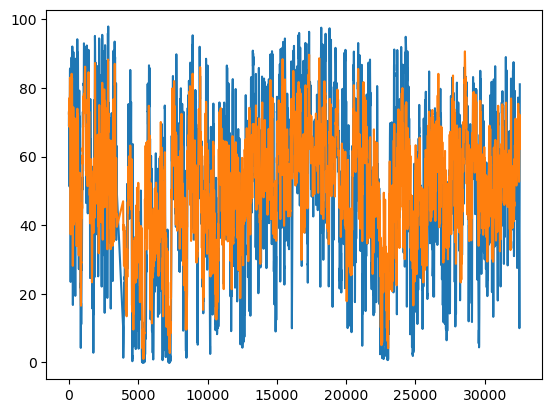

In [4]:
import matplotlib.pyplot as plt

plt.plot(uk_region.values.reshape(uk_region.values.shape[1]))
plt.plot(outer_region.values.reshape(uk_region.values.shape[1]))

In [18]:
uk_region = xr.where(
            ~dset_builder.mask.isnull(), dset_builder.nwp.isel(variable=1, step=1), np.nan
        ).isel(init_time=1).to_array().as_numpy()

uk_outer_region = xr.where(
            dset_builder.mask.isnull(), dset_builder.nwp.isel(variable=1, step=1), np.nan
        ).isel(init_time=1).to_array().as_numpy()

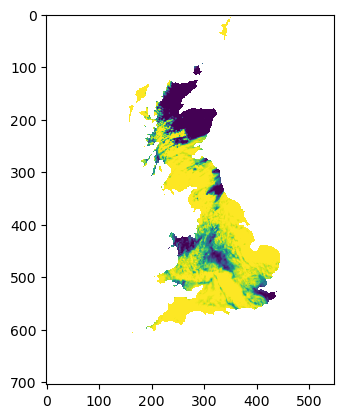

In [17]:
plt.imshow(uk_region.values.reshape(548, 704).T)

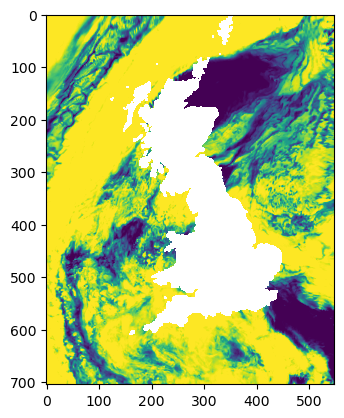

In [19]:
plt.imshow(uk_outer_region.values.reshape(548, 704).T)

In [5]:
nwp.coords["variable"]

<xarray.DataArray 'variable' (variable: 17)>
array(['cdcb', 'lcc', 'mcc', 'hcc', 'sde', 'hcct', 'dswrf', 'dlwrf', 'h', 't',
       'r', 'dpt', 'vis', 'si10', 'wdir10', 'prmsl', 'prate'], dtype='<U6')
Coordinates:
  * variable  (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'